In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import time

ALL = False
NO_SMOTE = True
SUB_PROCESSED_DIR = 'processed_62'
TEST_RATIO = 0.1

dtypes = {
    'msisdn': 'str',
    'start_time': 'str',
    'end_time': 'str',
    'call_event': 'category',
    'other_party': 'str',
    'ismultimedia': 'category',
    'home_area_code': 'str',
    'visit_area_code': 'str',
    'called_home_code': 'str',
    'called_code': 'str',
    'a_serv_type': 'int',
    'long_type1': 'int',
    'roam_type': 'int',
    'a_product_id': 'str',
    'open_datetime': 'str',
    'call_duration': 'int32',
    'cfee': 'float64',
    'lfee': 'float64',
    'hour': 'int8',
    'dayofweek': 'int',
    'phone1_type': 'int',
    'phone2_type': 'int',
    'phone1_loc_city': 'str',
    'phone1_loc_province': 'str',
    'phone2_loc_city': 'str',
    'phone2_loc_province': 'str',
    'update_time': 'str',
    'date': 'str',
    'date_c': 'str'
}

# 判断 processed 文件夹是否存在
import os
if not os.path.exists(f'../self_data/{SUB_PROCESSED_DIR}'):
    print("Creating processed data folder...")
    # 读取CSV文件
    labeled_data = pd.read_csv('../self_data/all_trainSet_res.csv', dtype=dtypes)
    labels = pd.read_csv('../self_data/all_trainSet_ans.csv', dtype=dtypes)

    validation_data = pd.read_csv('../self_data/sorted_validationSet_res_with_head.csv', dtype=dtypes)

    # 按照 msisdn 切分 train_data 和 test_data
    train_data_msisdn, test_data_msisdn = train_test_split(labels['msisdn'], test_size=TEST_RATIO, random_state=42, stratify=labels['is_sa'])
    train_data = labeled_data[labeled_data['msisdn'].isin(train_data_msisdn)]
    train_labels = labels[labels['msisdn'].isin(train_data_msisdn)]
    assert len(train_data['msisdn'].unique()) == len(train_data_msisdn)

    test_data = labeled_data[labeled_data['msisdn'].isin(test_data_msisdn)]
    test_labels = labels[labels['msisdn'].isin(test_data_msisdn)]
    assert len(test_data['msisdn'].unique()) == len(test_data_msisdn)


    # # 遍历 groupby('msisdn') 的结果，对每个 msisdn 进行数据增强
    # # ------
    from tqdm import tqdm
    import os
    import sys
    from utils.augmentation import Augmentation

    addition_train_data = []
    addition_train_labels = []

    times = 2
    ratio_range = 0.1
    pbar = tqdm(train_data.groupby('msisdn'))
    for msisdn, group in pbar:
        if msisdn == 0:
            continue
        # print(f"Augmenting msisdn {msisdn}")
        pbar.set_description(f"Augmenting msisdn {msisdn}")
        label = train_labels[train_labels['msisdn'] == msisdn].iloc[0]['is_sa']
        aug = Augmentation(group, label, 'msisdn', 'is_sa')
        # 对正负样本进行平衡 样本比 1:4
        if label == 1:
            res_df, res_labels = aug.times(ratio=ratio_range, times=3+4*times, method='mask')

            addition_train_data.append(res_df)
            addition_train_labels.append(res_labels)

            # res_df, res_labels = aug.times(window_size=100, step_size=80, times=1, method='sliding_window')

            # addition_train_data.append(res_df)
            # addition_train_labels.append(res_labels)
        else:
            res_df, res_labels = aug.times(ratio=ratio_range, times=times, method='mask')

            addition_train_data.append(res_df)
            addition_train_labels.append(res_labels)

            # res_df, res_labels = aug.times(window_size=100, step_size=80, times=1, method='sliding_window')

            # addition_train_data.append(res_df)
            # addition_train_labels.append(res_labels)
            
    addition_train_data = pd.concat(addition_train_data)
    addition_train_labels = pd.concat(addition_train_labels)

    # 将新数据加入到train_data中
    train_data = pd.concat([train_data, addition_train_data], ignore_index=True).reset_index(drop=True)
    train_labels = pd.concat([train_labels, addition_train_labels], ignore_index=True).reset_index(drop=True)

    # 按照 msisdn, start_time 排序
    sort_start_time = time.time()
    train_data = train_data.sort_values(by=['msisdn', 'start_time']).reset_index(drop=True)
    train_labels = train_labels.sort_values(by=['msisdn']).reset_index(drop=True)
    print('sort time:', time.time() - sort_start_time)

    labels_aug = pd.concat([train_labels, test_labels], ignore_index=True).reindex()
    # ------------------

    # save
    print("Saving processed data...")
    os.makedirs(f'../self_data/{SUB_PROCESSED_DIR}', exist_ok=True)
    train_data.to_csv(f'../self_data/{SUB_PROCESSED_DIR}/train_data.csv', index=False)
    train_labels.to_csv(f'../self_data/{SUB_PROCESSED_DIR}/train_labels.csv', index=False)
    test_data.to_csv(f'../self_data/{SUB_PROCESSED_DIR}/test_data.csv', index=False)
    test_labels.to_csv(f'../self_data/{SUB_PROCESSED_DIR}/test_labels.csv', index=False)

    labels_aug.to_csv(f'../self_data/{SUB_PROCESSED_DIR}/labels_aug.csv', index=False)

    validation_data.to_csv(f'../self_data/{SUB_PROCESSED_DIR}/validation_data.csv', index=False)
    # TODO: test_data

else:
    print("Reading processed data...")
    train_data = pd.read_csv(f'../self_data/{SUB_PROCESSED_DIR}/train_data.csv', dtype=dtypes)
    train_labels = pd.read_csv(f'../self_data/{SUB_PROCESSED_DIR}/train_labels.csv', dtype=dtypes)
    test_data = pd.read_csv(f'../self_data/{SUB_PROCESSED_DIR}/test_data.csv', dtype=dtypes)
    test_labels = pd.read_csv(f'../self_data/{SUB_PROCESSED_DIR}/test_labels.csv', dtype=dtypes)

    labels_aug = pd.read_csv(f'../self_data/{SUB_PROCESSED_DIR}/labels_aug.csv', dtype=dtypes)

    validation_data = pd.read_csv(f'../self_data/{SUB_PROCESSED_DIR}/validation_data.csv', dtype=dtypes)

labeled_data_aug = pd.concat([train_data, test_data], ignore_index=True).reindex()
assert len(labeled_data_aug['msisdn'].unique()) == len(labels_aug['msisdn'].unique())

# 转换时间格式
labeled_data_aug['start_time'] = pd.to_datetime(labeled_data_aug['start_time'], format='%Y%m%d%H%M%S')
labeled_data_aug['end_time'] = pd.to_datetime(labeled_data_aug['end_time'], format='%Y%m%d%H%M%S')
labeled_data_aug['open_datetime'] = pd.to_datetime(labeled_data_aug['open_datetime'], format='%Y%m%d%H%M%S')
labeled_data_aug['update_time'] = pd.to_datetime(labeled_data_aug['update_time'])
labeled_data_aug['date'] = pd.to_datetime(labeled_data_aug['date'])

validation_data['start_time'] = pd.to_datetime(validation_data['start_time'], format='%Y%m%d%H%M%S')
validation_data['end_time'] = pd.to_datetime(validation_data['end_time'], format='%Y%m%d%H%M%S')
validation_data['open_datetime'] = pd.to_datetime(validation_data['open_datetime'], format='%Y%m%d%H%M%S',errors='coerce')
validation_data['update_time'] = pd.to_datetime(validation_data['update_time'])
validation_data['date'] = pd.to_datetime(validation_data['date'])

Reading processed data...


In [3]:
# 为每条记录添加start_time_diff，记录 start_time 与上一条记录的 start_time 之差 (单位：秒)
start_time_diff = labeled_data_aug.groupby('msisdn')['start_time'].diff().dt.total_seconds().fillna(0).reset_index(drop=True)
# 将该列加入到数据集中
labeled_data_aug['start_time_diff'] = start_time_diff.copy()
# time_diff_start2end = train_data.groupby('msisdn')['end_time'].diff().dt.total_seconds().fillna(0)
start_time_diff = validation_data.groupby('msisdn')['start_time'].diff().dt.total_seconds().fillna(0).reset_index(drop=True)
validation_data['start_time_diff'] = start_time_diff.copy()

数据特征处理

In [4]:
# 聚合特征
def aggregate_features(data):
    return data.groupby('msisdn').agg({
    'call_duration': [
        ('sum', 'sum'), 
        ('mean', 'mean'), 
        ('max', 'max'), 
        ('std', 'std'),
        ('quantile_25', lambda x: x.quantile(0.25)), 
        ('quantile_50', lambda x: x.quantile(0.50)), 
        ('quantile_75', lambda x: x.quantile(0.75)),
    ],
    'cfee': [
        ('sum', 'sum'),
        ('std', 'std'), 
        ('mean', 'mean'),
    ],
    'lfee': [
        ('sum', 'sum'), 
        ('mean', 'mean'),
        ('std', 'std'),
    ],
    'hour': [
        ('mean', 'mean'), 
        ('std', 'std'), 
        ('max', 'max'), 
        ('min', 'min'),
    ],
    'dayofweek': [
        ('std', 'std'), 
        ('magic', lambda x: x.value_counts().mean()), 
        ('work_day_num', lambda x: x[x.isin([1,2,3,4,5])].count()), 
        ('weekend_num', lambda x: x[x.isin([6,7])].count()),
        ('mode', lambda x: x.mode().values[0]),
        ('work_day_weekend_diff', lambda x: (x[x.isin([1,2,3,4,5])].count() - x[x.isin([6,7])].count()) / (x[x.isin([1,2,3,4,5])].count() + x[x.isin([6,7])].count())),
    ],
    # 'home_area_code': [
    #     ('home_area_code_nunique', 'nunique')
    # ],
    'visit_area_code': [
        ('nunique', 'nunique'),
        ('times_not_at_home_area', lambda x: x[x != x.shift()].count()/x.count())
    ],
    'called_home_code': [
        ('nunique', 'nunique'),
        ('called_diff_home_code', lambda x: x[x != x.shift()].count() / x.count())
    ],
    'called_code': [
        ('nunique', 'nunique'),
        ('diff', lambda x: x[x != x.shift()].count()/ x.count())
    ],
    'open_datetime': [
        ('open_count', 'nunique')
    ],
    'other_party': [
        ('account_person_num', 'nunique'),
        ('called_diff_home_code', lambda x: x[x != x.shift()].count() / x.count())
    ],
    'a_serv_type': [
        ('call_num', lambda x: x[x.isin([1, 3])].count()), 
        ('called_num', lambda x: x[x == 2].count()),
        ('call_called_normalized_diff', lambda x: (x[x.isin([1, 3])].count() - x[x == 2].count()) /  (x[x.isin([1, 3])].count() + x[x == 2].count())),
    ],
    'start_time_diff': [
        ('start_time_diff_mean', 'mean'), 
        ('start_time_diff_std', 'std'), 
        ('max', 'max'), 
        ('coefficient_of_variation', lambda x: x.std() / x.mean()),
    ], 
    # 'phone1_type': [
    #     ('nunique', 'nunique'),
    #     ('mode', lambda x: x.mode().values[0])
    # ],
    # 'distance': [
    #     ('sum', 'sum'), 
    #     ('std', 'std'), 
    #     ('max', 'max'), 
    #     ('quantile_25', lambda x: x.quantile(0.25)), 
    #     ('quantile_50', lambda x: x.quantile(0.50)), 
    #     ('quantile_75', lambda x: x.quantile(0.75)),
    # ]
})

labeled_aug_features = aggregate_features(labeled_data_aug)
validation_features = aggregate_features(validation_data)

labeled_aug_features.columns = ['+'.join(col).strip() for col in labeled_aug_features.columns.values]
validation_features.columns = ['+'.join(col).strip() for col in validation_features.columns.values]

labeled_aug_features.columns = labeled_aug_features.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '').str.replace('>', '').str.replace('(', '').str.replace(')', '').str.replace(',', '').str.replace(' ', '_')
validation_features.columns = validation_features.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '').str.replace('>', '').str.replace('(', '').str.replace(')', '').str.replace(',', '').str.replace(' ', '_')

# 重置索引
labeled_aug_features = labeled_aug_features.reset_index()
validation_features = validation_features.reset_index()

# 合并标签数据
labeled_aug_features = labeled_aug_features.merge(labels_aug, on='msisdn', how='left')
# 打印结果
# labeled_aug_features

# # 添加 ae 的编码特征
# labeled_ae = pd.read_csv('../data/ae/train.csv', dtype=dtypes)
# valid_ae = pd.read_csv('../data/ae/val.csv', dtype=dtypes)
# labeled_aug_features = labeled_aug_features.merge(labeled_ae, on='msisdn', how='left')
# validation_features = validation_features.merge(valid_ae, on='msisdn', how='left')

C:\Users\shiwenbo\AppData\Local\Temp\ipykernel_4540\2867686233.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ('called_diff_home_code', lambda x: x[x != x.shift()].count() / x.count())
C:\Users\shiwenbo\AppData\Local\Temp\ipykernel_4540\2867686233.py:50: RuntimeWarning: invalid value encountered in scalar divide
  ('diff', lambda x: x[x != x.shift()].count()/ x.count())


In [5]:
labeled_aug_features.columns

Index(['msisdn', 'call_duration+sum', 'call_duration+mean',
       'call_duration+max', 'call_duration+std', 'call_duration+quantile_25',
       'call_duration+quantile_50', 'call_duration+quantile_75', 'cfee+sum',
       'cfee+std', 'cfee+mean', 'lfee+sum', 'lfee+mean', 'lfee+std',
       'hour+mean', 'hour+std', 'hour+max', 'hour+min', 'dayofweek+std',
       'dayofweek+magic', 'dayofweek+work_day_num', 'dayofweek+weekend_num',
       'dayofweek+mode', 'dayofweek+work_day_weekend_diff',
       'visit_area_code+nunique', 'visit_area_code+times_not_at_home_area',
       'called_home_code+nunique', 'called_home_code+called_diff_home_code',
       'called_code+nunique', 'called_code+diff', 'open_datetime+open_count',
       'other_party+account_person_num', 'other_party+called_diff_home_code',
       'a_serv_type+call_num', 'a_serv_type+called_num',
       'a_serv_type+call_called_normalized_diff',
       'start_time_diff+start_time_diff_mean',
       'start_time_diff+start_time_diff_std

In [6]:
len(labeled_aug_features.columns)

41

In [7]:
def get_nan(train):
    # 获取 train 中的 nan值
    train_nan = train[train.isnull().T.any()]
    # 统计 每列含有的 nan 数量
    for col in train.columns:
        if train[col].isnull().sum() > 0:
            print(col, train[col].isnull().sum())

    return train_nan
get_nan(labeled_aug_features), get_nan(validation_features)

call_duration+std 146
cfee+std 146
lfee+std 146
hour+std 146
dayofweek+std 146
called_home_code+called_diff_home_code 1
called_code+diff 1
start_time_diff+start_time_diff_std 146
start_time_diff+coefficient_of_variation 146
call_duration+std 78
cfee+std 78
lfee+std 78
hour+std 78
dayofweek+std 78
start_time_diff+start_time_diff_std 78
start_time_diff+coefficient_of_variation 78


(         msisdn  call_duration+sum  call_duration+mean  call_duration+max  \
 330     1005436                 25                25.0                 25   
 945     1010686                 16                16.0                 16   
 1755    1013277                351               351.0                351   
 1950    1013990                 56                56.0                 56   
 2127    1015735                 66                66.0                 66   
 ...         ...                ...                 ...                ...   
 128202  2419249                  2                 2.0                  2   
 129292  2423456                 14                14.0                 14   
 132326  2500562                 23                23.0                 23   
 132693  2502357                 74                74.0                 74   
 132764  2502602                507               507.0                507   
 
         call_duration+std  call_duration+quantile_25  \
 330 

In [8]:
# 一般只有 std 会出现 nan 值故所有的 nan 值填充为 0
labeled_aug_features = labeled_aug_features.fillna(0)
validation_features = validation_features.fillna(0)

def get_nan(train):
    # 获取 train 中的 nan值
    train_nan = train[train.isnull().T.any()]
    # 统计 每列含有的 nan 数量
    for col in train.columns:
        if train[col].isnull().sum() > 0:
            print(col, train[col].isnull().sum())

    return train_nan
get_nan(labeled_aug_features), get_nan(validation_features)

(Empty DataFrame
 Columns: [msisdn, call_duration+sum, call_duration+mean, call_duration+max, call_duration+std, call_duration+quantile_25, call_duration+quantile_50, call_duration+quantile_75, cfee+sum, cfee+std, cfee+mean, lfee+sum, lfee+mean, lfee+std, hour+mean, hour+std, hour+max, hour+min, dayofweek+std, dayofweek+magic, dayofweek+work_day_num, dayofweek+weekend_num, dayofweek+mode, dayofweek+work_day_weekend_diff, visit_area_code+nunique, visit_area_code+times_not_at_home_area, called_home_code+nunique, called_home_code+called_diff_home_code, called_code+nunique, called_code+diff, open_datetime+open_count, other_party+account_person_num, other_party+called_diff_home_code, a_serv_type+call_num, a_serv_type+called_num, a_serv_type+call_called_normalized_diff, start_time_diff+start_time_diff_mean, start_time_diff+start_time_diff_std, start_time_diff+max, start_time_diff+coefficient_of_variation, is_sa]
 Index: []
 
 [0 rows x 41 columns],
 Empty DataFrame
 Columns: [msisdn, call_du

In [9]:
# # # 交叉特征
# # # 将所有特征两两相乘
# from itertools import combinations
# from tqdm import tqdm

# def cross_features(data):
#     cross_features = []
#     new_features = []
#     cross_cols = data.columns.tolist()
#     rm_cols = ['msisdn', 'is_sa']
#     for col in rm_cols:
#         if col in cross_cols:
#             cross_cols.remove(col)

#     for i, j in tqdm(combinations(cross_cols, 2), total=len(cross_cols) * (len(cross_cols) - 1) // 2):
#         new_features.append(data[i] * data[j])
#         cross_features.append(f'{i}_cross_{j}')
#     new_features = pd.concat(new_features, axis=1)
#     new_features.columns = cross_features
#     data = pd.concat([data, new_features], axis=1)
#     return data, cross_features

# labeled_aug_features, _ = cross_features(labeled_aug_features)
# validation_features, _ = cross_features(validation_features)

In [10]:
X = labeled_aug_features.drop(['msisdn'], axis=1)
y = labeled_aug_features['is_sa']
X_validation = validation_features.drop(['msisdn'], axis=1)

n_sample = y.shape[0]
n_pos_sample = y[y ==1].shape[0]
n_neg_sample = y[y == 0].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特征维数：', X.shape[1])

样本个数：133591; 正样本占29.31%; 负样本占70.69%
特征维数： 40


In [11]:
labeled_aug_features.columns

Index(['msisdn', 'call_duration+sum', 'call_duration+mean',
       'call_duration+max', 'call_duration+std', 'call_duration+quantile_25',
       'call_duration+quantile_50', 'call_duration+quantile_75', 'cfee+sum',
       'cfee+std', 'cfee+mean', 'lfee+sum', 'lfee+mean', 'lfee+std',
       'hour+mean', 'hour+std', 'hour+max', 'hour+min', 'dayofweek+std',
       'dayofweek+magic', 'dayofweek+work_day_num', 'dayofweek+weekend_num',
       'dayofweek+mode', 'dayofweek+work_day_weekend_diff',
       'visit_area_code+nunique', 'visit_area_code+times_not_at_home_area',
       'called_home_code+nunique', 'called_home_code+called_diff_home_code',
       'called_code+nunique', 'called_code+diff', 'open_datetime+open_count',
       'other_party+account_person_num', 'other_party+called_diff_home_code',
       'a_serv_type+call_num', 'a_serv_type+called_num',
       'a_serv_type+call_called_normalized_diff',
       'start_time_diff+start_time_diff_mean',
       'start_time_diff+start_time_diff_std

In [12]:
# TODO use all_X to impute
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)

In [13]:
imputer2 = SimpleImputer(strategy='most_frequent')
X_validation = imputer2.fit_transform(X_validation)

In [14]:
X.shape

(133591, 40)

In [15]:
X_validation.shape

(13005, 39)

In [16]:
y.shape

(133591,)

In [17]:
assert len(train_labels) + len(test_labels) == len(labeled_aug_features)
len(train_labels), len(test_labels)

(129732, 3859)

In [18]:
from sklearn.utils import shuffle
# 将 msisdn 和 is_sa 并入 X 再划分
train_data_msisdn = train_labels['msisdn']
test_data_msisdn = test_labels['msisdn']
X_df = pd.DataFrame(X, columns=labeled_aug_features.drop(['msisdn'], axis=1).columns)
X_df = pd.concat([labeled_aug_features[['msisdn']], X_df], axis=1)
train_set = X_df[X_df['msisdn'].isin(train_data_msisdn)][X_df.columns[1:]]
test_set = X_df[X_df['msisdn'].isin(test_data_msisdn)][X_df.columns[1:]]

print(f"1 samples / 0 samples in train set: {len(train_set[train_set['is_sa'] == 1])} / {len(train_set[train_set['is_sa'] == 0])}")
print(f"1 samples / 0 samples in test set: {len(test_set[test_set['is_sa'] == 1])} / {len(test_set[test_set['is_sa'] == 0])}")

if ALL:
    # if not NO_SMOTE:
    #     smote = SMOTE(random_state=42)    # 处理过采样的方法
    #     X, y = smote.fit_resample(X, y)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)
    train_len = len(test_set) + len(train_set)
    test_len = 0
else:
    # X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size= 0.3,random_state=42, shuffle=True)
    # X_train, y_train = shuffle(X_train, y_train, random_state=42)
    train_len, test_len = len(train_set), len(test_set)

    # if not NO_SMOTE:
    #     smote = SMOTE(random_state=42)    # 处理过采样的方法
    #     X_train, y_train = smote.fit_resample(X_train, y_train)
    #     print('通过SMOTE方法平衡正负样本后')
    #     n_sample = y_train.shape[0]
    #     n_pos_sample = y_train[y_train == 1].shape[0]
    #     n_neg_sample = y_train[y_train == 0].shape[0]
    #     print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
    #                                                     n_pos_sample / n_sample,
    #                                                     n_neg_sample / n_sample))
    #     print('特征维数：', X.shape[1])

1 samples / 0 samples in train set: 38768 / 90964
1 samples / 0 samples in test set: 384 / 3475


In [19]:
columns = labeled_aug_features.columns.tolist()
columns.remove('msisdn')
valid_set = np.c_[X_validation, np.zeros(X_validation.shape[0])]
valid_set = pd.DataFrame(valid_set, columns=columns)
valid_set['is_sa'] = -1

In [20]:
train_set.head()

,call_duration+sum,call_duration+mean,call_duration+max,call_duration+std,call_duration+quantile_25,call_duration+quantile_50,call_duration+quantile_75,cfee+sum,cfee+std,cfee+mean,...,other_party+account_person_num,other_party+called_diff_home_code,a_serv_type+call_num,a_serv_type+called_num,a_serv_type+call_called_normalized_diff,start_time_diff+start_time_diff_mean,start_time_diff+start_time_diff_std,start_time_diff+max,start_time_diff+coefficient_of_variation,is_sa
0,6369.0,68.483871,1129.0,128.481906,20.00,37.0,78.00,0.0,0.0,0.0,...,44.0,0.860215,62.0,31.0,0.333333,13200.580645,24019.169180,105436.0,1.819554,0.0
1,5466.0,65.071429,1129.0,127.232241,19.75,37.0,74.25,0.0,0.0,0.0,...,39.0,0.845238,55.0,29.0,0.309524,14614.928571,27163.200021,146225.0,1.858593,0.0
2,5851.0,69.654762,1129.0,134.535121,19.75,37.0,75.75,0.0,0.0,0.0,...,41.0,0.833333,54.0,30.0,0.285714,14614.928571,25230.069991,105642.0,1.726322,0.0
3,375.0,20.833333,156.0,39.165186,3.50,8.0,13.50,0.0,0.0,0.0,...,6.0,0.333333,13.0,5.0,0.444444,14917.611111,23149.372122,74415.0,1.551815,1.0
4,287.0,16.882353,156.0,36.486097,3.00,8.0,9.00,0.0,0.0,0.0,...,5.0,0.294118,12.0,5.0,0.411765,15795.117647,27012.641878,79546.0,1.710189,1.0


In [21]:
test_set.describe()

,call_duration+sum,call_duration+mean,call_duration+max,call_duration+std,call_duration+quantile_25,call_duration+quantile_50,call_duration+quantile_75,cfee+sum,cfee+std,cfee+mean,...,other_party+account_person_num,other_party+called_diff_home_code,a_serv_type+call_num,a_serv_type+called_num,a_serv_type+call_called_normalized_diff,start_time_diff+start_time_diff_mean,start_time_diff+start_time_diff_std,start_time_diff+max,start_time_diff+coefficient_of_variation,is_sa
count,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,...,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3.859000e+03,3859.000000,3859.000000
mean,10406.521897,98.551688,1019.947396,161.949909,22.429386,44.574112,101.245400,118.738015,2.351438,1.248072,...,35.999223,0.723654,61.325214,56.421353,-0.020429,26362.870725,41034.896147,1.675445e+05,1.821371,0.099508
std,12760.882888,92.222400,1033.736896,173.551887,16.044677,37.889841,113.887055,700.271881,21.844227,22.155837,...,58.313255,0.163836,84.329243,65.668060,0.383948,34537.860324,50357.713939,1.385666e+05,0.744165,0.299381
min,9.000000,7.500000,9.000000,0.000000,3.000000,7.500000,8.750000,0.000000,0.000000,0.000000,...,1.000000,0.020408,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2636.000000,49.842071,327.500000,58.460836,15.000000,28.000000,54.000000,0.000000,0.000000,0.000000,...,10.000000,0.651446,15.000000,17.000000,-0.262935,8164.690789,15486.485752,7.947500e+04,1.424679,0.000000
50%,6210.000000,74.507692,702.000000,108.303908,20.000000,37.500000,75.500000,0.000000,0.000000,0.000000,...,21.000000,0.755814,36.000000,37.000000,-0.012658,15687.100000,24991.270244,1.254000e+05,1.694879,0.000000
75%,13446.500000,114.641912,1437.000000,206.710735,25.250000,50.000000,111.000000,0.000000,0.000000,0.000000,...,42.000000,0.833333,74.000000,70.000000,0.201156,30406.071646,46539.805125,2.033185e+05,2.030944,0.000000
max,148852.000000,1585.351351,12031.000000,2985.972392,557.500000,1078.000000,2462.750000,13060.000000,1158.022021,1345.500000,...,1182.000000,1.000000,1188.000000,918.000000,1.000000,419491.666667,724139.196063,1.255654e+06,14.622485,1.000000


In [22]:
all_set = pd.concat([train_set, test_set, valid_set], axis=0).reset_index(drop=True)
labeled_data_len = train_set.shape[0] + test_set.shape[0]

In [23]:
test_set.shape, train_set.shape, valid_set.shape, all_set.shape

((3859, 40), (129732, 40), (13005, 40), (146596, 40))

In [24]:
NO_SMOTE = False

In [25]:
labeled_set, valid_set = all_set.iloc[:labeled_data_len].copy(), all_set.iloc[labeled_data_len:].copy()
labeled_set.reset_index(drop=True, inplace=True)
valid_set.reset_index(drop=True, inplace=True)
# 有一些值在SMOTE后对数变换后为 NaN，需要删除这些数据
print(labeled_set.isnull().sum().sum())
labeled_set = labeled_set.dropna()
print(labeled_set.isnull().sum().sum())
assert valid_set.shape[0] == validation_features.shape[0]

# 重新划分训练集和测试集
if not ALL:
    train_set, test_set = labeled_set.iloc[:train_len].copy(), labeled_set.iloc[train_len:].copy()
    train_set.reset_index(drop=True, inplace=True)
    test_set.reset_index(drop=True, inplace=True)

    # remove_columns = ['distance_distance_std', "start_time_diff_start_time_diff_max", "distance_distance_quantile_75"]

    # remove_columns = ["lfee_lfee_std", "lfee_lfee_mean", 'call_duration_call_duration_max', "distance_distance_quantile_50", "call_duration_call_duration_quantile_25"]
    # remove_columns = ["7", "6", "lfee_lfee_mean", "hour_hour_std", "1", "call_duration_call_duration_quantile_75", "3", "cfee_cfee_std", "start_time_diff_start_time_diff_max", "call_duration_call_duration_max", "dayofweek_dayofweek_mode", "distance_distance_quantile_75", "cfee_cfee_mean"] # , "visit_area_code_visit_area_code_nunique", "visit_area_code_visit_area_code_nunique"
    # remove_columns = ['visit_area_code+nunique_cross_start_time_diff+max', "distance+std"]
    # remove_columns = ['dayofweek+std', 'start_time_diff+max', 'distance+quantile_75', 'lfee+mean', 'lfee+std', 'lfee+sum', 'cfee+sum', '6', 'visit_area_code+nunique']
    remove_columns = ['cfee+std', 'start_time_diff+start_time_diff_std', 'lfee+mean', 'lfee+sum', 'lfee+std']
    train_set = train_set.drop(remove_columns, axis=1)
    test_set = test_set.drop(remove_columns, axis=1)
    valid_set = valid_set.drop(remove_columns, axis=1)

    # 对采样数据做 smote
    if not NO_SMOTE:
        smote = SMOTE(random_state=42)    # 处理过采样的方法
        X_train, y_train = smote.fit_resample(train_set.drop(['is_sa'], axis=1), train_set['is_sa'])
        train_set = pd.concat([X_train, y_train], axis=1)
        print('通过SMOTE方法平衡正负样本后')
        n_sample = y_train.shape[0]
        n_pos_sample = y_train[y_train == 1].shape[0]
        n_neg_sample = y_train[y_train == 0].shape[0]
        print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                        n_pos_sample / n_sample,
                                                        n_neg_sample / n_sample))
    assert train_set.shape[1] == test_set.shape[1] == valid_set.shape[1]
else:
    if not NO_SMOTE:
        # BUG:
        # 对 all_set 做 smote
        smote = SMOTE(random_state=42)    # 处理过采样的方法
        X_train, y_train = smote.fit_resample(labeled_set.drop(['is_sa'], axis=1), labeled_set['is_sa'])
        labeled_set = pd.concat([X_train, y_train], axis=1)
        print('通过SMOTE方法平衡正负样本后')
        n_sample = y_train.shape[0]
        n_pos_sample = y_train[y_train == 1].shape[0]
        n_neg_sample = y_train[y_train == 0].shape[0]
        print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                        n_pos_sample / n_sample,
                                                        n_neg_sample / n_sample))
    remove_columns = ['0', '1', '2', '3', '4', '5', '6', '7', 'cfee+std', 'start_time_diff+start_time_diff_std', 'lfee+mean', 'lfee+sum', 'lfee+std']
    labeled_set = labeled_set.drop(remove_columns, axis=1)
    valid_set = valid_set.drop(remove_columns, axis=1)
    test_set = test_set.drop(remove_columns, axis=1)
    assert labeled_set.shape[1] == valid_set.shape[1] == test_set.shape[1]
    

0
0
通过SMOTE方法平衡正负样本后
样本个数：181928; 正样本占50.00%; 负样本占50.00%


In [26]:
train_set.shape, test_set.shape, valid_set.shape

((181928, 35), (3859, 35), (13005, 35))

In [27]:
# 使用 autogluon 训练
from autogluon.tabular import TabularPredictor
# import ray
# 使用防止过拟合的超参数
# hyperparameters = {
#     'GBM': {'lambda_l1': 1e-2, 'lambda_l2': 1e-2},
#     'FASTAI': {'dropout_prob': 0.2}
# }
# ray.shutdown()
# ray.init(include_dashboard=True, object_store_memory=10**9)  # Increase object store memory

# 输入数据X_train, y_train
if not ALL:
    # 交叉验证训练
    model = TabularPredictor(label='is_sa', eval_metric='f1', problem_type='binary').fit(train_set, presets='medium_quality', time_limit=3600)
    # , excluded_model_types=['KNN']
    # model = TabularPredictor(label='is_sa', eval_metric='f1', problem_type='binary').fit(train_set, presets='best_quality', time_limit=3600)
else:
    model = TabularPredictor(label='is_sa', eval_metric='f1', problem_type='binary').fit(labeled_set, presets='best_quality', num_bag_folds=10, time_limit=3600)

c:\Users\shiwenbo\miniforge3\envs\ag-new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20241101_025907"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          48
Memory Avail:       72.64 GB / 127.90 GB (56.8%)
Disk Space Avail:   369.18 GB / 476.93 GB (77.4%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels\ag-20241101_025907"
Train Data Rows:    181928
Train Data Columns: 34
Label Column:       is_sa
Problem Type:       binary
Preprocessing data ...
Selected class <--> label m

[1000]	valid_set's binary_logloss: 0.251206	valid_set's f1: 0.919668
[2000]	valid_set's binary_logloss: 0.168759	valid_set's f1: 0.962495
[3000]	valid_set's binary_logloss: 0.120973	valid_set's f1: 0.980501
[4000]	valid_set's binary_logloss: 0.0902408	valid_set's f1: 0.986061
[5000]	valid_set's binary_logloss: 0.0684435	valid_set's f1: 0.990818
[6000]	valid_set's binary_logloss: 0.0521594	valid_set's f1: 0.99481
[7000]	valid_set's binary_logloss: 0.040073	valid_set's f1: 0.996803
[8000]	valid_set's binary_logloss: 0.0311215	valid_set's f1: 0.996803
[9000]	valid_set's binary_logloss: 0.0246983	valid_set's f1: 0.998001
[10000]	valid_set's binary_logloss: 0.0200516	valid_set's f1: 0.9984


	0.9984	 = Validation score   (f1)
	73.71s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 3521.93s of the 3521.93s of remaining time.


[1000]	valid_set's binary_logloss: 0.172297	valid_set's f1: 0.960863
[2000]	valid_set's binary_logloss: 0.0980046	valid_set's f1: 0.983567
[3000]	valid_set's binary_logloss: 0.0593198	valid_set's f1: 0.991981
[4000]	valid_set's binary_logloss: 0.0388564	valid_set's f1: 0.995192
[5000]	valid_set's binary_logloss: 0.0255634	valid_set's f1: 0.995595
[6000]	valid_set's binary_logloss: 0.0175875	valid_set's f1: 0.997999
[7000]	valid_set's binary_logloss: 0.0124681	valid_set's f1: 0.997999


	0.998	 = Validation score   (f1)
	60.03s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 3461.26s of the 3461.26s of remaining time.
	0.9932	 = Validation score   (f1)
	9.2s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to 3451.49s of the 3451.48s of remaining time.
	0.9936	 = Validation score   (f1)
	11.3s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 3439.64s of the 3439.64s of remaining time.
	0.9964	 = Validation score   (f1)
	421.37s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ... Training model for up to 3018.22s of the 3018.22s of remaining time.
	0.9875	 = Validation score   (f1)
	4.65s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesEntr ... Training model for up to 3012.91s of the 3012.9s of remaining time.
	0.9895	 = Validation 

[1000]	valid_set's binary_logloss: 0.0729807	valid_set's f1: 0.99161
[2000]	valid_set's binary_logloss: 0.024305	valid_set's f1: 0.997996
[3000]	valid_set's binary_logloss: 0.00979304	valid_set's f1: 0.999199


	0.9992	 = Validation score   (f1)
	42.3s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 2585.58s of remaining time.
	Ensemble Weights: {'LightGBMLarge': 1.0}
	0.9992	 = Validation score   (f1)
	0.59s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1015.15s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 93853.3 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20241101_025907")


In [28]:
if not ALL:
    print(model.evaluate(test_set))

{'f1': 0.4013722126929674, 'accuracy': 0.9095620627105467, 'balanced_accuracy': 0.6405451888489209, 'mcc': 0.3804713109523436, 'roc_auc': 0.8235236810551558, 'precision': 0.5879396984924623, 'recall': 0.3046875}


In [29]:
feature_importance = model.feature_importance(test_set if not ALL else labeled_set)
print(feature_importance)
feature_importance

Computing feature importance via permutation shuffling for 34 features using 3859 rows with 5 shuffle sets...
	33.79s	= Expected runtime (6.76s per shuffle set)
	5.63s	= Actual runtime (Completed 5 of 5 shuffle sets)


                                          importance    stddev   p_value  n  \
called_home_code+nunique                    0.106958  0.017537  0.000084  5   
other_party+account_person_num              0.050308  0.008402  0.000090  5   
start_time_diff+coefficient_of_variation    0.027788  0.013198  0.004627  5   
a_serv_type+called_num                      0.026491  0.005519  0.000214  5   
call_duration+std                           0.023893  0.005059  0.000227  5   
hour+std                                    0.022840  0.002195  0.000010  5   
visit_area_code+times_not_at_home_area      0.022379  0.016244  0.018455  5   
a_serv_type+call_num                        0.019242  0.010152  0.006642  5   
dayofweek+work_day_num                      0.018661  0.016328  0.031470  5   
start_time_diff+start_time_diff_mean        0.017923  0.009773  0.007421  5   
start_time_diff+max                         0.015137  0.006531  0.003297  5   
a_serv_type+call_called_normalized_diff     0.010127

,importance,stddev,p_value,n,p99_high,p99_low
called_home_code+nunique,0.106958,0.017537,0.000084,5,0.143067,0.070850
other_party+account_person_num,0.050308,0.008402,0.000090,5,0.067609,0.033007
start_time_diff+coefficient_of_variation,0.027788,0.013198,0.004627,5,0.054963,0.000613
a_serv_type+called_num,0.026491,0.005519,0.000214,5,0.037855,0.015127
call_duration+std,0.023893,0.005059,0.000227,5,0.034309,0.013476
hour+std,0.022840,0.002195,0.000010,5,0.027359,0.018321
visit_area_code+times_not_at_home_area,0.022379,0.016244,0.018455,5,0.055826,-0.011068
a_serv_type+call_num,0.019242,0.010152,0.006642,5,0.040145,-0.001662
dayofweek+work_day_num,0.018661,0.016328,0.031470,5,0.052281,-0.014960
start_time_diff+start_time_diff_mean,0.017923,0.009773,0.007421,5,0.038046,-0.002199


In [30]:
# leaderboard
if not ALL:
    leaderboard = model.leaderboard(test_set, silent=True)
    print(leaderboard)
else:
    leaderboard = model.leaderboard(labeled_set, silent=True)
    print(leaderboard)
leaderboard

                  model  score_test  score_val eval_metric  pred_time_test  \
0              CatBoost    0.428125   0.996401          f1        0.070250   
1            LightGBMXT    0.425000   0.998400          f1        0.310579   
2               XGBoost    0.423756   0.997999          f1        0.324615   
3        NeuralNetTorch    0.415094   0.967690          f1        0.060000   
4      RandomForestEntr    0.411093   0.993564          f1        0.405767   
5              LightGBM    0.403941   0.997999          f1        0.187082   
6         LightGBMLarge    0.401372   0.999199          f1        0.216560   
7   WeightedEnsemble_L2    0.401372   0.999199          f1        0.225559   
8        ExtraTreesGini    0.398089   0.987515          f1        0.526655   
9        ExtraTreesEntr    0.389525   0.989533          f1        0.544565   
10     RandomForestGini    0.380165   0.993159          f1        0.418759   
11       KNeighborsDist    0.183230   0.898130          f1      

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.428125,0.996401,f1,0.070250,0.009000,421.367004,0.070250,0.009000,421.367004,1,True,7
1,LightGBMXT,0.425000,0.998400,f1,0.310579,0.114264,73.713361,0.310579,0.114264,73.713361,1,True,3
2,XGBoost,0.423756,0.997999,f1,0.324615,0.027999,56.916941,0.324615,0.027999,56.916941,1,True,10
3,NeuralNetTorch,0.415094,0.967690,f1,0.060000,0.036004,321.626226,0.060000,0.036004,321.626226,1,True,11
4,RandomForestEntr,0.411093,0.993564,f1,0.405767,0.119641,11.301616,0.405767,0.119641,11.301616,1,True,6
5,LightGBM,0.403941,0.997999,f1,0.187082,0.039999,60.033531,0.187082,0.039999,60.033531,1,True,4
6,LightGBMLarge,0.401372,0.999199,f1,0.216560,0.024638,42.297163,0.216560,0.024638,42.297163,1,True,12
7,WeightedEnsemble_L2,0.401372,0.999199,f1,0.225559,0.026637,42.884859,0.008999,0.002000,0.587696,2,True,13
8,ExtraTreesGini,0.398089,0.987515,f1,0.526655,0.106176,4.645438,0.526655,0.106176,4.645438,1,True,8
9,ExtraTreesEntr,0.389525,0.989533,f1,0.544565,0.101999,4.787480,0.544565,0.101999,4.787480,1,True,9


              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      3475
         1.0       0.59      0.30      0.40       384

    accuracy                           0.91      3859
   macro avg       0.76      0.64      0.68      3859
weighted avg       0.89      0.91      0.90      3859



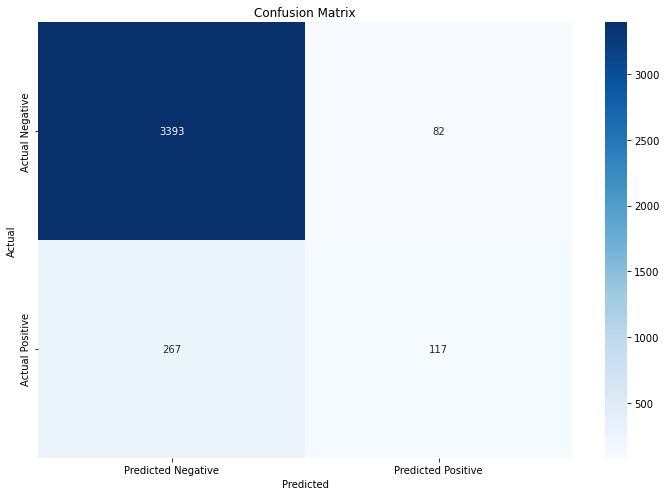

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 假设 model 已经训练好，并且 test_set 已经定义
if not ALL:
    y_pred = model.predict(test_set)
    y_true = test_set['is_sa']
    
    # 打印分类报告
    print(classification_report(y_true, y_pred))
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 可视化混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    os.makedirs("../vis", exist_ok=True)
    plt.savefig("../vis/confusion_matrix.png")
    plt.show()

In [32]:
# 模型决策阈值微调
threadhold = 0.2
if not ALL:
    y_pred_proba = model.predict_proba(test_set)
    # print(y_pred_proba)
    y_pred = (y_pred_proba.iloc[:, 1] > threadhold).astype(int)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3475
         1.0       0.43      0.44      0.43       384

    accuracy                           0.89      3859
   macro avg       0.68      0.69      0.68      3859
weighted avg       0.89      0.89      0.89      3859

[[3247  228]
 [ 215  169]]


In [33]:
valid_set

,call_duration+sum,call_duration+mean,call_duration+max,call_duration+std,call_duration+quantile_25,call_duration+quantile_50,call_duration+quantile_75,cfee+sum,cfee+mean,hour+mean,...,open_datetime+open_count,other_party+account_person_num,other_party+called_diff_home_code,a_serv_type+call_num,a_serv_type+called_num,a_serv_type+call_called_normalized_diff,start_time_diff+start_time_diff_mean,start_time_diff+max,start_time_diff+coefficient_of_variation,is_sa
0,28781.0,150.685864,3433.0,368.413006,26.00,56.0,128.00,0.0,0.0,13.963351,...,1.0,29.0,0.691099,78.0,113.0,-0.183246,6604.434555,70979.0,1.677037,-1.0
1,45.0,15.000000,22.0,7.000000,11.50,15.0,18.50,0.0,0.0,16.666667,...,1.0,3.0,1.000000,2.0,1.0,0.333333,151026.333333,358005.0,1.227899,-1.0
2,10441.0,105.464646,1018.0,187.808104,22.00,47.0,72.50,0.0,0.0,16.969697,...,1.0,45.0,0.777778,40.0,59.0,-0.191919,12536.474747,89245.0,1.637631,-1.0
3,2784.0,49.714286,225.0,37.122752,24.75,39.5,66.50,0.0,0.0,13.714286,...,1.0,6.0,0.517857,30.0,26.0,0.071429,22129.500000,141632.0,1.444801,-1.0
4,19280.0,61.012658,439.0,67.178085,20.00,41.0,72.25,0.0,0.0,14.196203,...,1.0,178.0,0.715190,148.0,168.0,-0.063291,3864.389241,94609.0,3.541749,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13000,14677.0,119.325203,2491.0,357.738972,15.00,27.0,57.00,0.0,0.0,12.601626,...,1.0,39.0,0.723577,54.0,69.0,-0.121951,10255.146341,78981.0,1.548514,-1.0
13001,4440.0,80.727273,359.0,81.001247,20.00,50.0,108.00,0.0,0.0,13.181818,...,1.0,21.0,0.745455,14.0,41.0,-0.490909,22530.509091,328175.0,2.135565,-1.0
13002,14668.0,70.181818,1141.0,101.785622,22.00,40.0,82.00,0.0,0.0,15.655502,...,1.0,54.0,0.693780,100.0,109.0,-0.043062,5955.488038,75474.0,2.048014,-1.0
13003,3505.0,79.659091,368.0,81.336208,27.00,62.0,79.25,0.0,0.0,12.522727,...,1.0,21.0,0.704545,12.0,32.0,-0.454545,28175.477273,239119.0,1.656892,-1.0


In [34]:
test_set.shape

(3859, 35)

In [35]:
# 预测
y_validation_pred = model.predict(valid_set.drop('is_sa', axis=1))

# 将预测结果与 msisdn 对应起来
validation_results = validation_features[['msisdn']].copy()
validation_results['is_sa'] = y_validation_pred.astype(int)

print(validation_results.describe())

# 保存结果到CSV文件
import time
time_str = time.strftime("%Y%m%d%H%M%S", time.localtime())
file_name = './valid_large_data_{}.csv'.format(time_str) if ALL else './valid_small_data_{}.csv'.format(time_str)
validation_results.to_csv(file_name, index=False)
print(file_name)

              is_sa
count  13005.000000
mean       0.067666
std        0.251182
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
./valid_small_data_20241101111614.csv


In [36]:
# import numpy as np
# from sklearn.metrics import f1_score, classification_report, confusion_matrix

# # 自动调整最佳阈值
# if not ALL:
#     y_true = test_set['is_sa']
#     y_pred_proba = model.predict_proba(test_set)

#     thresholds = np.arange(0.0, 1.0, 0.01)
#     f1_scores = []

#     for threshold in thresholds:
#         y_pred = (y_pred_proba.iloc[:, 1] >= threshold).astype(int)
#         f1 = f1_score(y_true, y_pred)
#         f1_scores.append(f1)

#     best_threshold = thresholds[np.argmax(f1_scores)]
#     print(f'最佳阈值：{best_threshold}')
#     print(f'最佳 F1 分数：{max(f1_scores)}')

#     # 使用最佳阈值进行预测
#     y_pred = (y_pred_proba.iloc[:, 1] >= best_threshold).astype(int)
#     print(classification_report(y_true, y_pred))
#     print(confusion_matrix(y_true, y_pred))

In [37]:
# # 阈值微调版结果
# best_threshold = 0.3
# # 使用最佳决策阈值进行预测
# y_validation_pred_proba = model.predict_proba(valid_set.drop('is_sa', axis=1))
# y_validation_pred = (y_validation_pred_proba.iloc[:, 1] >= best_threshold).astype(int)

# # 将预测结果与 msisdn 对应起来
# validation_results = validation_features[['msisdn']].copy()
# validation_results['is_sa'] = y_validation_pred.astype(int)

# print(validation_results.describe())

# # 保存结果到CSV文件
# import time
# time_str = time.strftime("%Y%m%d%H%M%S", time.localtime())
# file_name = './valid_large_data_{}.csv'.format(time_str) if ALL else './valid_small_data_{}.csv'.format(time_str)
# validation_results.to_csv(file_name, index=False)
# print(file_name)